In [1]:
from btgp.data_utils import load_dataset
from btgp.gp import ONGP, bit_order_to_inv_permutation
from btgp.gp_mixture import GPMixture
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import time
import gc

In [2]:
datasets = [
#     "pol",
#     "elevators",
#     "bike",
#     "kin40k",
#     "protein",
#     "keggdirected",
    "slice",
#     "keggundirected",
#     "3droad",
#     "song",
#     "buzz",
#     "houseelectric",
]

In [3]:
from __future__ import annotations

import warnings
from math import ceil
from typing import Dict, List, Optional, Tuple, Union

import torch

from torch import Tensor
from torch.distributions import Normal
from torch.quasirandom import SobolEngine
def initialize_q_batch(X: Tensor, Y: Tensor, n: int, eta: float = 1.0) -> Tensor:
    r"""Heuristic for selecting initial conditions for candidate generation.
    This heuristic selects points from `X` (without replacement) with probability
    proportional to `exp(eta * Z)`, where `Z = (Y - mean(Y)) / std(Y)` and `eta`
    is a temperature parameter.
    When using an acquisiton function that is non-negative and possibly zero
    over large areas of the feature space (e.g. qEI), you should use
    `initialize_q_batch_nonneg` instead.
    Args:
        X: A `b x batch_shape x q x d` tensor of `b` - `batch_shape` samples of
            `q`-batches from a d`-dim feature space. Typically, these are generated
            using qMC sampling.
        Y: A tensor of `b x batch_shape` outcomes associated with the samples.
            Typically, this is the value of the batch acquisition function to be
            maximized.
        n: The number of initial condition to be generated. Must be less than `b`.
        eta: Temperature parameter for weighting samples.
    Returns:
        A `n x batch_shape x q x d` tensor of `n` - `batch_shape` `q`-batch initial
        conditions, where each batch of `n x q x d` samples is selected independently.
    Example:
        >>> # To get `n=10` starting points of q-batch size `q=3`
        >>> # for model with `d=6`:
        >>> qUCB = qUpperConfidenceBound(model, beta=0.1)
        >>> Xrnd = torch.rand(500, 3, 6)
        >>> Xinit = initialize_q_batch(Xrnd, qUCB(Xrnd), 10)
    """
    n_samples = X.shape[0]
    batch_shape = X.shape[1:-2] or torch.Size()
    if n > n_samples:
        raise RuntimeError(
            f"n ({n}) cannot be larger than the number of "
            f"provided samples ({n_samples})"
        )
    elif n == n_samples:
        return X

    Ystd = Y.std(dim=0)
    if torch.any(Ystd == 0):
        warnings.warn(
            "All acquisition values for raw samples points are the same for "
            "at least one batch. Choosing initial conditions at random.",
            RuntimeWarning,
        )
        return X[torch.randperm(n=n_samples, device=X.device)][:n]

    max_val, max_idx = torch.max(Y, dim=0)
    Z = (Y - Y.mean(dim=0)) / Ystd
    etaZ = eta * Z
    weights = torch.exp(etaZ)
    while torch.isinf(weights).any():
        etaZ *= 0.5
        weights = torch.exp(etaZ)
    if batch_shape == torch.Size():
        idcs = torch.multinomial(weights, n)
    else:
        idcs = batched_multinomial(
            weights=weights.permute(*range(1, len(batch_shape) + 1), 0), num_samples=n
        ).permute(-1, *range(len(batch_shape)))
    # make sure we get the maximum
    if max_idx not in idcs:
        idcs[-1] = max_idx
    if batch_shape == torch.Size():
        return X[idcs]
    else:
        return X.gather(
            dim=0, index=idcs.view(*idcs.shape, 1, 1).expand(n, *X.shape[1:])
        )

In [4]:
def initialize_bit_order(gp, n=20, raw_samples=1000):
    bit_orders_weights = []
    train_nlls = []
    # initialize bit order
    orig_weight = gp.weights[-1].item()
    for _ in range(raw_samples):
        for weight in (orig_weight, 0.5, 0.9):
            gp.weights[-1] = weight
            gp.weights[:-1] = (1-weight)/(gp.weights.shape[0]-1)
            gp.random_bit_order()
    #         gp.random_weights()
            bit_orders_weights.append(torch.cat([gp.bit_order.clone(), gp.weights[-1:].clone().view(1,1).expand(gp.bit_order.shape[0], 1)], dim=-1))
            gp.process()
            train_nlls.append(gp.nll)
    return initialize_q_batch(X=torch.stack(bit_orders_weights, dim=0), Y=-torch.stack(train_nlls), n=n)
#     return bit_orders, train_nlls

In [5]:
NUM_RESTARTS = 20

In [6]:
path_start = "../data/uci/"
test_rmses_all = {}
test_nlls_all = {}
train_times_all = {}
predict_times_all = {}
init_times_all = {}
mixture_rmse_all_perf_weighting = {}
mixture_nll_all_perf_weighting = {}
mixture_rmse_all_uniform_weighting = {}
mixture_nll_all_uniform_weighting = {}
all_init_bit_orders = {}
all_final_bit_orders = {}
all_last_bit_weights = {}
SEEDS = [0,1,2]
torch.manual_seed(0)
NUM_RESTARTS = 20
RAW_SAMPLES = 160
n_gps = NUM_RESTARTS

performance_weighting = 100 # maybe sqrt(n data points) is a good anchor?

for name in datasets:
    test_rmses = []
    test_nlls = []
    mixture_rmse_perf_weightings = []
    mixture_nll_perf_weightings = []
    mixture_rmse_uniform_weightings = []
    mixture_nll_uniform_weightings = []
    mixture_init_bit_orders = []
    mixture_last_bit_weights = []
    mixture_final_bit_orders = []
    train_times = []
    predict_times = []
    init_times = []
    torch.manual_seed(0)
    for seed in SEEDS:
        mixture_rmse_perf_weighting = {}
        mixture_nll_perf_weighting = {}
        mixture_rmse_uniform_weighting = {}
        mixture_nll_uniform_weighting = {}
        train_x, train_y, val_x, val_y, test_x, test_y = load_dataset(
            path_start + f"{name}/{name}.mat",
            random_split=seed,
        )
        del val_x, val_y
        LAMBDA = 1/train_x.shape[0]

        test_y = test_y.to(device=device, dtype=torch.float64)
        gp = ONGP(train_x.to(dtype=torch.float64, device=device),
                  train_y.to(dtype=torch.float64, device=device),
                  test_x.to(dtype=torch.float64, device=device), lambd=1e-5, precision="auto")
        # initialize bit order
        init_time = time.time()
        bit_orders = initialize_bit_order(gp, n=NUM_RESTARTS, raw_samples=RAW_SAMPLES)
        mixture_init_bit_orders.append(bit_orders.clone())
        last_bit_weights = bit_orders[:,0, -1]
        bit_orders = bit_orders[:,:, :-1].long()
        
        init_times.append(time.time()-init_time)
        _test_nlls = []
        _test_rmses = []
        _train_nlls = []
        gp_pop = GPMixture(train_x.to(device=device, dtype=torch.float64),
          train_y.to(device=device, dtype=torch.float64),
          test_x.to(device=device, dtype=torch.float64),
          lambd=LAMBDA)
        for i in range(NUM_RESTARTS):
            gp.weights[-1] = last_bit_weights[i]
            gp.weights[:-1].fill_((1-last_bit_weights[i])/(gp.weights.shape[0]-1))
            gp.bit_order = bit_orders[i]
            gp.bit_order_inv_perm = bit_order_to_inv_permutation(gp.bit_order, gp.precision)
            
            mixture_init_bit_orders.append(bit_orders[i].clone())
            mixture_last_bit_weights.append(last_bit_weights[i].clone())
            gp.process()
            print()
            print("Training the weight vector and the bit order:")
            train_time = time.time()
            gp.opt_weights_and_bit_order_bfgs(max_iter=1000, verbose=False)
            mixture_final_bit_orders.append(gp.bit_order.clone())
            train_times.append(time.time() - train_time)
            gp.save(path=f"{name}_seed{seed}_gp{i}___")
            _train_nlls.append(gp.nll)
            predict_time = time.time()
            test_nll = gp.calculate_test_nll(test_y)
            predict_times.append(time.time() - predict_time)
            _test_nlls.append(test_nll)
            test_rmse = gp.rmse(test_y.view(-1))
            _test_rmses.append(test_rmse)
            print(f"Finished restart {i}")
            
            gp_pop.add(gp)
            del gp
            torch.cuda.empty_cache()
            gc.collect()
            gp = ONGP(train_x.to(dtype=torch.float64, device=device),
                  train_y.to(dtype=torch.float64, device=device),
                  test_x.to(dtype=torch.float64, device=device), lambd=LAMBDA, precision="auto")
        del gp
        torch.cuda.empty_cache()
        gc.collect()
        best_idx = torch.argmin(torch.stack(_train_nlls)).item()
        test_nlls.append(_test_nlls[best_idx])
        test_rmses.append(_test_rmses[best_idx])
        for n_gps in (5, 10, 15, 20):
            _gp_pop = GPMixture(train_x.to(device=device, dtype=torch.float64),
              train_y.to(device=device, dtype=torch.float64),
              test_x.to(device=device, dtype=torch.float64),
              lambd=LAMBDA
            )
            for j in range(n_gps):
                _gp_pop.add(gp_pop.gps[j])
            _gp_pop.process_all()
            _gp_pop.get_nlls()
            # compute NLL, RMSE using performance weighting
            test_nll_perf_weighting = _gp_pop.gp_mixture_nll(test_y, weight_func=lambda nlls: torch.exp(-performance_weighting*nlls))
            test_rmse_perf_weighting = _gp_pop.gp_mixture_rmse(test_y, weight_func=lambda nlls: torch.exp(-performance_weighting*nlls))
            # compute NLL RMSE using uniform weighting
            test_nll_uniform_weighting = _gp_pop.gp_mixture_nll(test_y, weight_func=lambda nlls: torch.ones_like(nlls))
            test_rmse_uniform_weighting = _gp_pop.gp_mixture_rmse(test_y, weight_func=lambda nlls: torch.ones_like(nlls))
            mixture_nll_perf_weighting[n_gps] = test_nll_perf_weighting
            mixture_rmse_perf_weighting[n_gps] = test_rmse_perf_weighting
            mixture_nll_uniform_weighting[n_gps] = test_nll_uniform_weighting
            mixture_rmse_uniform_weighting[n_gps] = test_rmse_uniform_weighting
            del _gp_pop
            
        del gp_pop, test_y
        torch.cuda.empty_cache()
        gc.collect()
        mixture_nll_perf_weightings.append(mixture_nll_perf_weighting)
        mixture_rmse_perf_weightings.append(mixture_rmse_perf_weighting)
        mixture_nll_uniform_weightings.append(mixture_nll_uniform_weighting)
        mixture_rmse_uniform_weightings.append(mixture_rmse_uniform_weighting)
    
    test_rmses_all[name] = test_rmses
    test_nlls_all[name] = test_nlls
    train_times_all[name] = train_times
    predict_times_all[name] = predict_times
    init_times_all[name] = init_times
    mixture_rmse_all_perf_weighting[name] = mixture_rmse_perf_weightings
    mixture_nll_all_perf_weighting[name] = mixture_nll_perf_weightings
    mixture_rmse_all_uniform_weighting[name] = mixture_rmse_uniform_weightings
    mixture_nll_all_uniform_weighting[name] = mixture_nll_uniform_weightings
    mixture_nll_all_uniform_weighting[name] = mixture_nll_uniform_weightings
    all_last_bit_weights[name] = mixture_last_bit_weights
    all_init_bit_orders[name] = mixture_init_bit_orders
    all_final_bit_orders[name] = mixture_final_bit_orders
    with open(f"uci_results_mixture_ensemble_{name}_torch_bfgs_160_raw_samps.data", "wb") as f:
        torch.save({
            "test_rmses_all": test_rmses_all, 
            "test_nlls_all": test_nlls_all, 
            "train_times_all": train_times_all, 
            "predict_times_all": predict_times_all,
            "init_times_all": init_times_all,
            "mixture_rmses_all_perf_weighting": mixture_rmse_all_perf_weighting,
            "mixture_nlls_all_perf_weighting": mixture_nll_all_perf_weighting,
            "mixture_rmses_all_uniform_weighting": mixture_rmse_all_uniform_weighting,
            "mixture_nlls_all_uniform_weighting": mixture_nll_all_uniform_weighting,
            "all_last_bit_weights": all_last_bit_weights,
            "all_init_bit_orders": all_init_bit_orders,
            "all_final_bit_orders": all_final_bit_orders,
        }, f)

dataset_path: ../data/uci/slice/slice.mat
data.shape: torch.Size([53500, 386])
train_x.shape: torch.Size([34240, 385])
full kernel size: 4.4 GB
train_x: min 0.000, max 1.000, mean 0.212, std 0.314
val_x: min 0.000, max 250000.000, mean 0.285, std 137.713
test_x: min 0.000, max 4.737, mean 0.212, std 0.315
train_y: min -2.022, max 2.257, mean -0.000, std 1.000
val_y: min -2.017, max 2.272, mean 0.018, std 1.011
test_y: min -2.028, max 2.268, mean 0.016, std 1.009



/home/sdaulton/anaconda3/envs/effgp/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



Training the weight vector and the bit order:
Finished restart 0

Training the weight vector and the bit order:
Finished restart 1

Training the weight vector and the bit order:
Finished restart 2

Training the weight vector and the bit order:
Finished restart 3

Training the weight vector and the bit order:
Finished restart 4

Training the weight vector and the bit order:
Finished restart 5

Training the weight vector and the bit order:
Finished restart 6

Training the weight vector and the bit order:
Finished restart 7

Training the weight vector and the bit order:
Finished restart 8

Training the weight vector and the bit order:
Finished restart 9

Training the weight vector and the bit order:
Finished restart 10

Training the weight vector and the bit order:
Finished restart 11

Training the weight vector and the bit order:
Finished restart 12

Training the weight vector and the bit order:
Finished restart 13

Training the weight vector and the bit order:
Finished restart 14

Trai

In [7]:
import torch
with open(f"uci_results_mixture_ensemble_slice_torch_bfgs_160_raw_samps.data", "rb") as f:
    res = torch.load(f)

## test SLSQP

In [18]:
from math import sqrt
for k, v in res["mixture_rmses_all_perf_weighting"].items():
    v = torch.cat([vi[20].view(1) for vi in v])
    m = round(v.mean().item(), 3)
    two_se = round(2*v.std().item()/sqrt(3), 3)
    print(f"{k} & ${m:.3f} \pm {two_se:.3f}$")

slice & $0.116 \pm 0.009$


In [20]:
from math import sqrt
for k, v in res["test_rmses_all"].items():
    v = torch.cat([vi.view(1) for vi in v])
    m = round(v.mean().item(), 3)
    two_se = round(2*v.std().item()/sqrt(3), 3)
    print(f"{k} & ${m:.3f} \pm {two_se:.3f}$")

slice & $0.132 \pm 0.009$


In [21]:
from math import sqrt
for k, v in res["mixture_nlls_all_perf_weighting"].items():
    v = torch.cat([vi[20].view(1) for vi in v])
    m = round(v.mean().item(), 3)
    two_se = round(2*v.std().item()/sqrt(3), 3)
    print(f"{k} & ${m:.3f} \pm {two_se:.3f}$")

slice & $-2.527 \pm 0.147$


In [22]:
from math import sqrt
for k, v in res["test_nlls_all"].items():
    v = torch.cat([vi.view(1) for vi in v])
    m = round(v.mean().item(), 3)
    two_se = round(2*v.std().item()/sqrt(3), 3)
    print(f"{k} & ${m:.3f} \pm {two_se:.3f}$")

slice & $-1.092 \pm 0.147$


In [23]:
import numpy as np
name_to_train_time = {}
train_times_all = res["train_times_all"]
for name in train_times_all.keys():
    start = 0
    end = NUM_RESTARTS
    train_times = train_times_all[name]
    time_per_seed = []
    while start < len(train_times):
        time_per_seed.append(sum(train_times[start:end]))
        start = end
        end += NUM_RESTARTS
    time_per_seed = np.array(time_per_seed)
    v = time_per_seed
    m = round(v.mean(), 1)
    two_se = round(2*v.std()/sqrt(3), 1)
    print(f"{name} & ${m:.1f} \pm {two_se:.1f}$")
    name_to_train_time[name] = v

slice & $3070.5 \pm 55.5$


In [24]:
# all times
import numpy as np
for name in init_times_all.keys():
    v = np.array(init_times_all[name]) + name_to_train_time[name]
    m = round(v.mean(), 1)
    two_se = round(2*v.std()/sqrt(3), 1)
    print(f"{name} & ${m:.1f} \pm {two_se:.1f}$")


slice & $3120.3 \pm 55.4$


In [15]:
import pickle
with open(f"name_to_train_time_{name}", "wb") as fout:
    pickle.dump(name_to_train_time, fout)

In [16]:
time_per_seed

array([3011.88505077, 3070.01156473, 3129.6554563 ])

Text(0, 0.5, 'Test NLL')

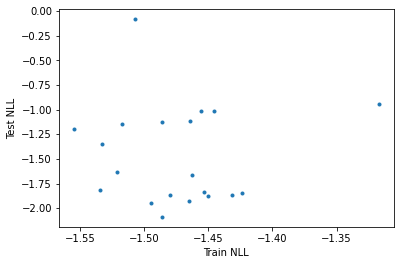

In [17]:
import matplotlib.pyplot as plt
plt.plot(torch.stack(_train_nlls).cpu(), torch.stack(_test_nlls).cpu(), '.')
plt.xlabel("Train NLL")
plt.ylabel("Test NLL")

In [38]:
sqrt((147.2*sqrt(3))**2 * 8)/sqrt(3)

416.34447276263916